# Análise de Sentimento Financeiro

Neste notebook, buscamos entender o sentimento financeiro por meio de análises de sentimentos em textos. O objetivo é classificar os sentimentos expressos em textos financeiros como positivos, negativos ou neutros.

Essa tarefa se faz necessária devido à crescente quantidade de dados financeiros disponíveis, como notícias, relatórios e comentários de analistas. A análise de sentimentos pode ajudar investidores e analistas a tomar decisões informadas com base nas emoções expressas nesses textos. É uma ferramenta diretamente aplicável ao feedback de clientes, relatórios financeiros e até mesmo em redes sociais, onde as opiniões sobre ações e mercados podem influenciar o comportamento do mercado.


In [1]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento de texto e NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


# Utilitários
from scipy import stats
from sklearn.exceptions import ConvergenceWarning
import warnings
from typing import Dict, List, Set, Tuple, Optional
from collections import Counter

# Configurações
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Downloads necessários do NLTK
try:
    nltk.wordnet.WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet', quiet=True)

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True)

### Carregando os Dados

In [2]:
# Leitura de Dados
try:
    dataset_df = pd.read_csv("../data/data.csv") # Caminho original do notebook
except FileNotFoundError:
    print("Arquivo '../data/data.csv' não encontrado. Tentando 'data.csv' no diretório atual.")
    try:
        dataset_df = pd.read_csv("./data/data.csv") # Tentativa alternativa
    except FileNotFoundError:
        print("ERRO: Arquivo de dados não encontrado. Verifique o caminho.")
        exit()

display(dataset_df.info(),dataset_df.sample(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


None

,Sentence,Sentiment
1679,"LKAB , headquartered in Lulea , Sweden , is a ...",neutral
5282,Symphony Services provides development service...,neutral
5409,S&P downgrades Barclays and RBS on government ...,negative


### Funções Auxiliares

In [3]:
def load_loughran_mcdonald(file_path: str, categories: List[str] = None) -> Dict[str, Set[str]]:
    """
    Carrega o dicionário Loughran-McDonald de um arquivo CSV.

    Args:
        file_path: Caminho para o arquivo CSV do dicionário LM
        categories: Lista de categorias a serem carregadas


    Returns:
        Dicionário com sets de palavras por categoria
    """
    if categories is None:
        categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious',
                     'Strong_Modal', 'Weak_Modal', 'Constraining']

    lexicons = {cat: set() for cat in categories}

    try:
        df = pd.read_csv(file_path, usecols=['Word'] + categories,
                        keep_default_na=False, na_values=[''])

        for category in categories:
            if category in df.columns:
                numeric_col = pd.to_numeric(df[category], errors='coerce')
                mask = numeric_col.notna() & (numeric_col > 0)
                words = df.loc[mask, 'Word']
                lexicons[category].update(word.upper() for word in words if isinstance(word, str))

        print(f"Dicionário LM carregado: {file_path}")

    except FileNotFoundError:
        print(f"Arquivo não encontrado: {file_path}")
        print("Continuando com dicionários vazios...")
    except Exception as e:
        print(f"Erro ao carregar dicionário: {e}")

    return lexicons

# =============================================================================
# ENGENHARIA DE FEATURES
# =============================================================================

def tokenize_text(text: str) -> List[str]:
    """Tokeniza texto e converte para maiúsculas (padrão LM)."""
    if pd.isna(text):
        return []
    return [word.upper() for word in re.findall(r'\b\w+\b', str(text))]

def count_lexicon_words(tokens: List[str], word_set: Set[str]) -> int:
    """Conta palavras que estão no conjunto de léxico."""
    return sum(1 for word in tokens if word in word_set)

def calculate_basic_features(df: pd.DataFrame, text_column: str = 'Sentence') -> pd.DataFrame:
    """Calcula features básicas de texto."""
    result = df.copy()

    # Features básicas
    result['tamanho_texto'] = result[text_column].str.len().fillna(0)
    result['tokens'] = result[text_column].apply(tokenize_text)
    result['qtd_palavras'] = result['tokens'].apply(len)
    result['qtd_exclamacao'] = result[text_column].str.count(r'\!').fillna(0)
    result['qtd_interrogacao'] = result[text_column].str.count(r'\?').fillna(0)
    result['razao_caixa_alta'] = result[text_column].apply(
        lambda x: sum(c.isupper() for c in str(x)) / len(str(x)) if len(str(x)) > 0 else 0
    )

    return result

def calculate_lm_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]]) -> pd.DataFrame:
    """Calcula features baseadas no dicionário Loughran-McDonald."""
    result = df.copy()

    # Features LM
    result['lm_positive'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Positive', set()))
    )
    result['lm_negative'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Negative', set()))
    )
    result['lm_uncertainty'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Uncertainty', set()))
    )
    result['lm_litigious'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Litigious', set()))
    )
    result['lm_constraining'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Constraining', set()))
    )

    # Score de sentimento
    result['lm_sentiment_score'] = result['lm_positive'] - result['lm_negative']

    return result

def create_all_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]],
                       text_column: str = 'Sentence') -> pd.DataFrame:
    """Cria todas as features necessárias."""
    # Features básicas
    df_features = calculate_basic_features(df, text_column)

    # Features LM
    df_features = calculate_lm_features(df_features, lm_lexicons)

    # Remove coluna de tokens (não é feature)
    df_features = df_features.drop(columns=['tokens'])

    # Preenche NaNs
    feature_columns = [col for col in df_features.columns
                      if col not in [text_column, 'Sentiment']]
    for col in feature_columns:
        df_features[col] = df_features[col].fillna(0)

    return df_features

# =============================================================================
# ANÁLISE ESTATÍSTICA
# =============================================================================

def balance_dataset(df: pd.DataFrame, target_column: str = 'Sentiment',
                   random_state: int = 42) -> pd.DataFrame:
    """Balanceia dataset através de subamostragem."""
    class_counts = df[target_column].value_counts()
    min_size = class_counts.min()

    balanced_dfs = []
    for class_label in class_counts.index:
        class_df = df[df[target_column] == class_label]
        sampled_df = class_df.sample(n=min_size, random_state=random_state)
        balanced_dfs.append(sampled_df)

    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"Dataset balanceado: {len(balanced_df)} amostras ({min_size} por classe)")
    return balanced_df

def test_feature_significance(df: pd.DataFrame, features: List[str],
                            target_column: str = 'Sentiment',
                            alpha: float = 0.05, show_output = False) -> Dict:
    """Testa significância estatística das features usando Kruskal-Wallis."""
    results = {}
    classes = sorted(df[target_column].unique())

    print(f"Testando {len(features)} features (alpha={alpha})")
    print("=" * 50)

    for feature in features:
        if show_output:
            print(f"\nFeature: {feature}")

        # Dados por grupo
        groups = [df[df[target_column] == cls][feature].dropna() for cls in classes]
        valid_groups = [group for group in groups if len(group) > 1]

        if len(valid_groups) < 2:
            print(f"  Dados insuficientes para teste")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}
            continue

        try:
            statistic, p_value = stats.kruskal(*valid_groups)
            significant = p_value < alpha

            results[feature] = {
                'p_value': p_value,
                'significant': significant,
                'statistic': statistic
            }


            status = "Significativo" if significant else "Não significativo"
            if show_output:
                print(f"  Kruskal-Wallis: H={statistic:.3f}, p={p_value:.4f} - {status}")

        except Exception as e:
            print(f"  Erro no teste: {e}")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}

    return results

def summarize_results(results: Dict) -> None:
    """Resumo dos resultados dos testes."""
    significant_features = [feat for feat, res in results.items()
                          if res['significant'] and not np.isnan(res['p_value'])]

    print("\n" + "=" * 50)
    print("RESUMO DOS RESULTADOS")
    print("=" * 50)

    print(f"\nFeatures significativas ({len(significant_features)}):")
    if significant_features:
        for feat in significant_features:
            p_val = results[feat]['p_value']
            print(f"  - {feat}: p={p_val:.4f}")
    else:
        print("  Nenhuma feature significativa encontrada")

    print(f"\nTotal de features testadas: {len(results)}")
    print(f"Features com dados válidos: {sum(1 for r in results.values() if not np.isnan(r['p_value']))}")

# =============================================================================
# VISUALIZAÇÃO
# =============================================================================

def plot_feature_distributions(df: pd.DataFrame, features: List[str],
                             target_column: str = 'Sentiment',
                             max_plots: int = 6) -> None:
    """Plota distribuições das features por classe."""
    features_to_plot = features[:max_plots]
    n_features = len(features_to_plot)

    if n_features == 0:
        return

    cols = min(3, n_features)
    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_features == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    classes = sorted(df[target_column].unique())

    for i, feature in enumerate(features_to_plot):
        ax = axes[i] if n_features > 1 else axes[0]

        sns.boxplot(data=df, x=target_column, y=feature, order=classes, ax=ax)
        ax.set_title(f'Distribuição: {feature}')
        ax.tick_params(axis='x', rotation=45)

    # Remove axes extras
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# =============================================================================
# PIPELINE PRINCIPAL
# =============================================================================

def run_sentiment_analysis(df: pd.DataFrame, lm_file_path: str,
                          use_balanced: bool = True,
                          text_column: str = 'Sentence',
                          target_column: str = 'Sentiment',
                          show_output: bool = True) -> Tuple[pd.DataFrame, Dict]:
    """
    Pipeline principal para análise de sentimentos financeiros.

    Args:
        df: DataFrame com os dados
        lm_file_path: Caminho para o dicionário LM
        use_balanced: Se True, balanceia o dataset
        text_column: Nome da coluna com texto
        target_column: Nome da coluna com sentimento
        show_output: Se True, exibe gráficos de distribuição

    Returns:
        Tuple com DataFrame processado e resultados dos testes
    """

    if show_output:
        print("INICIANDO ANÁLISE DE SENTIMENTOS FINANCEIROS")
        print("=" * 50)

    # 1. Carregar dicionário LM
    lm_lexicons = load_loughran_mcdonald(lm_file_path)

    # 2. Criar features
    print("\nCriando features...")
    df_features = create_all_features(df, lm_lexicons, text_column)

    # 3. Balancear dataset se solicitado
    if use_balanced:
        print("\nBalanceando dataset...")
        df_analysis = balance_dataset(df_features, target_column)
    else:
        df_analysis = df_features.copy()
        print(f"\nUsando dataset original: {len(df_analysis)} amostras")

    print(f"\nDistribuição das classes:")
    print(df_analysis[target_column].value_counts())

    # 4. Selecionar features para teste
    feature_columns = [col for col in df_analysis.columns
                      if col not in [text_column, target_column]]

    # 5. Testar significância
    print(f"\nTestando significância estatística...")
    results = test_feature_significance(df_analysis, feature_columns, target_column, show_output=show_output)

    significant_features = [feat for feat, res in results.items() if res['significant']]

    if show_output:
        if significant_features:
            print(f"\nVisualizando {len(significant_features)} features significativas...")
            plot_feature_distributions(df_analysis, significant_features, target_column, max_plots=len(significant_features))

    return df_analysis, significant_features


def create_complexity_features(text: str) -> Dict[str, float]:
    """
    Cria features de complexidade lexical a partir de um texto.
    Args:
        text: Texto a ser analisado
    Returns:
        Dicionário com features de complexidade
    """

    words = text.split()
    unique_words = set(words)

    # Métricas de complexidade
    return {
        'lexical_diversity': len(unique_words) / len(words) if len(words) > 0 else 0,
        'content_word_ratio': len([w for w in words if w.lower() not in stopwords.words('english')]) / len(words) if len(words) > 0 else 0
    }


def preprocess_sentences(df, column='Sentence', lang='english', remove_digits=True,
                         to_lower=True, remove_punct=True, do_lemmatize=True, remove_stop=True):
    """
    Preprocessa sentenças textuais com opções de limpeza, stopwords e lematização.

    Args:
        df (pd.DataFrame): DataFrame contendo a coluna com sentenças.
        column (str): Nome da coluna de entrada.
        lang (str): Idioma para stopwords e lematização.
        remove_digits (bool): Remove dígitos se True.
        to_lower (bool): Converte para minúsculo se True.
        remove_punct (bool): Remove pontuação (exceto ! e ?) se True.
        do_lemmatize (bool): Aplica lematização se True.
        remove_stop (bool): Remove stopwords se True.

    Returns:
        pd.Series: Série com as sentenças processadas.
    """

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words(lang)) if remove_stop else set()

    def process(sentence):
        if remove_digits:
            sentence = re.sub(r'\d+', '', sentence)
        if to_lower:
            sentence = sentence.lower()
        if remove_punct:
            sentence = re.sub(r'[^\w\s!?]', '', sentence)
        if remove_stop:
            sentence = " ".join(word for word in sentence.split() if word not in stop_words)
        if do_lemmatize:
            sentence = " ".join(lemmatizer.lemmatize(word) for word in word_tokenize(sentence))
        return sentence

    return df[column].apply(process)


def plotar_balanco_dados(df, coluna) -> None:
    """
    Cria e exibe um gráfico de barras customizado para a distribuição de sentimentos,
    incluindo a contagem absoluta e a porcentagem no topo de cada barra.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna com os rótulos de sentimento.
    """

    # Conta a ocorrência de cada sentimento
    contagem = df[coluna].value_counts()

    # Extrai os rótulos (sentimentos) e os tamanhos (contagens)
    rotulos = contagem.index.astype(str)
    tamanhos = contagem.values


    # Define um mapa de cores para manter a consistência visual
    mapa_cores = {
        'positive': 'lightgreen',
        'negative': 'lightcoral',
        'neutral': 'lightblue'
    }
    # Ordena as cores de acordo com os rótulos
    cores_ordenadas = [mapa_cores.get(rotulo, 'grey') for rotulo in rotulos]

    # Cria a figura e os eixos para um único gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(rotulos, tamanhos, color=cores_ordenadas, edgecolor='black')

    # Calcula o total para encontrar a porcentagem
    total_amostras = sum(tamanhos)

    # Cria uma lista de rótulos formatados (ex: "5 (55.6%)")
    rotulos_formatados = []
    for i in range(len(tamanhos)):
        tamanho = tamanhos[i]
        porcentagem = (tamanho / total_amostras) * 100
        rotulos_formatados.append(f'{tamanho} ({porcentagem:.1f}%)')

    # Adiciona os rótulos customizados no topo de cada barra
    ax.bar_label(bars, labels=rotulos_formatados, fontsize=11, fontweight='bold', padding=3)

    # --- Customização do Gráfico ---
    estilo_fonte_titulo = {'fontsize': 14, 'fontweight': 'bold'}
    estilo_fonte_eixos = {'fontsize': 12, 'fontweight': 'bold'}

    ax.set_title("Balanço das Classes de Sentimento", **estilo_fonte_titulo)
    ax.set_xlabel("Sentimento", **estilo_fonte_eixos)
    ax.set_ylabel("Número de Amostras", **estilo_fonte_eixos)

    ax.set_ylim(0, max(tamanhos) * 1.15)

    # Remove a borda superior e direita para um visual mais limpo
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Ajusta o layout e exibe o gráfico
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', alpha=0.0)
    plt.tight_layout()
    plt.show()


## Analise Exploratória

Inicialmente, vamos explorar os dados para entender melhor a distribuição dos sentimentos e as características dos textos.

In [4]:
print(dataset_df.isnull().sum())

Sentence     0
Sentiment    0
dtype: int64


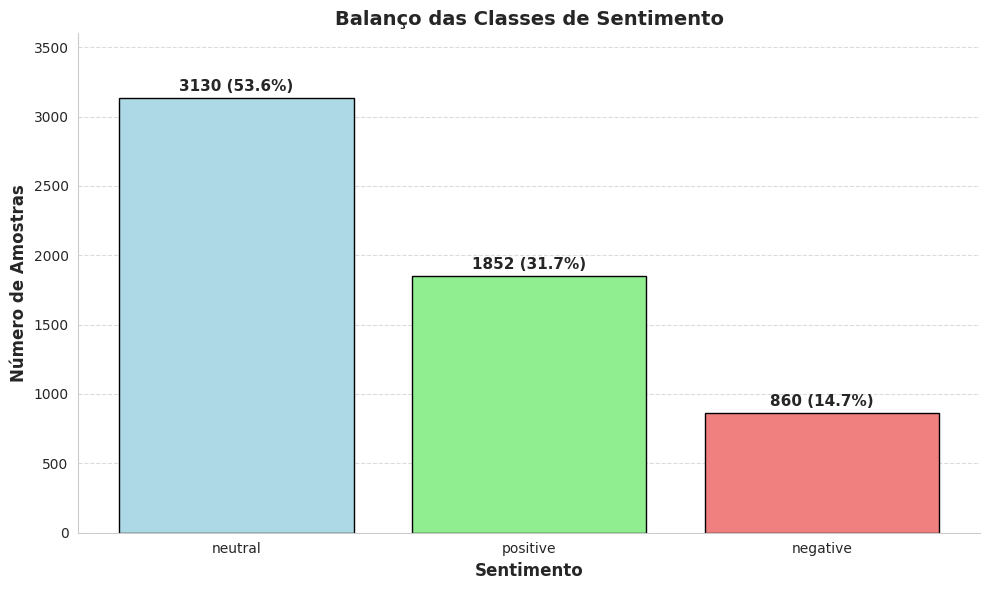

In [5]:
plotar_balanco_dados(dataset_df, 'Sentiment')


Se trata de uma base não balanceada, onde a classe "neutro" é a mais frequente, seguida por "positivo" e "negativo". Essa distribuição pode afetar o desempenho dos modelos de aprendizado de máquina, pois eles podem ter dificuldade em aprender a classificar corretamente as classes menos representadas.

In [6]:
# Calculate text lengths
dataset_df['comprimento_texto'] = dataset_df['Sentence'].apply(len)

# Calculate word counts
dataset_df['num_palavras'] = dataset_df['Sentence'].str.split().str.len()
# Calculate average word length
dataset_df['comprimento_medio_palavra'] = dataset_df['comprimento_texto'] / dataset_df['num_palavras']

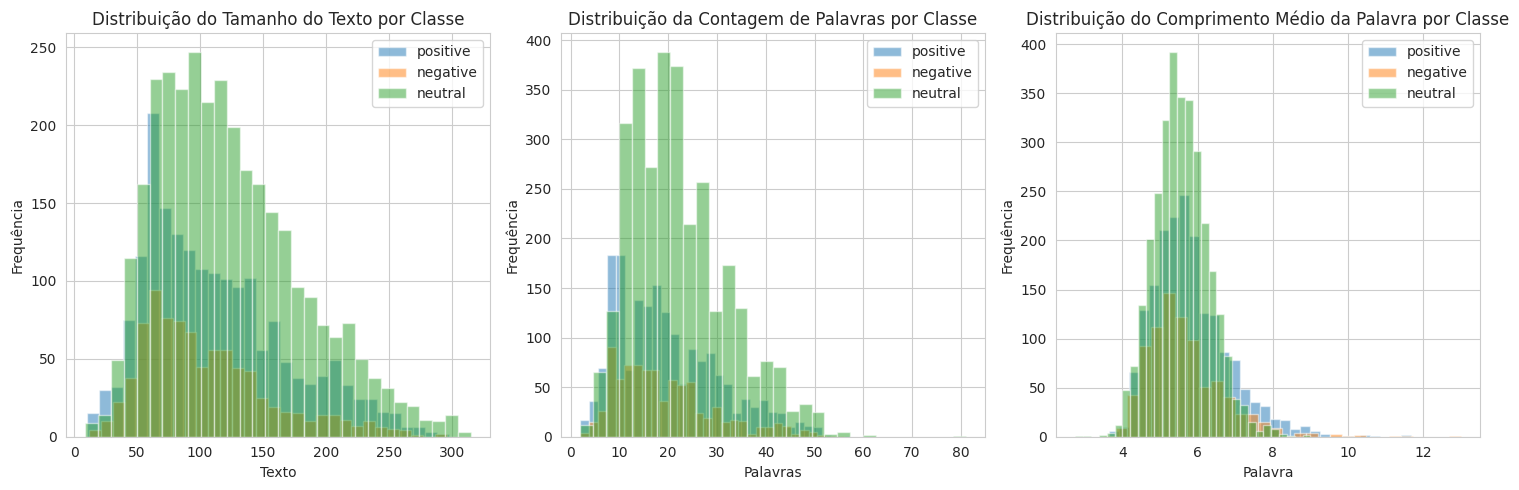

In [7]:
# Definir configurações do plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['comprimento_texto','num_palavras','comprimento_medio_palavra']
titles = ['Distribuição do Tamanho do Texto',
          'Distribuição da Contagem de Palavras',
          'Distribuição do Comprimento Médio da Palavra']
sentiments = ['positive', 'negative', 'neutral']

# Criar os três histogramas
for ax, feature, title in zip(axes, features, titles):
    for sentiment in sentiments:
        ax.hist(dataset_df[dataset_df['Sentiment'] == sentiment][feature],
                bins=30, alpha=0.5, label=sentiment)
    ax.set_title(f'{title} por Classe')
    ax.set_xlabel(title.split()[-1])
    ax.set_ylabel('Frequência')
    ax.legend()

plt.tight_layout()
plt.show()


Nota-se que o tamanho do texto, a contagem de palavras e o comprimento médio das palavras não apresentam variação nas distribuições, apenas variando a contagem de classes. Dessa froam não é possível determinar a relevância desses atributos para a classificação de sentimentos.

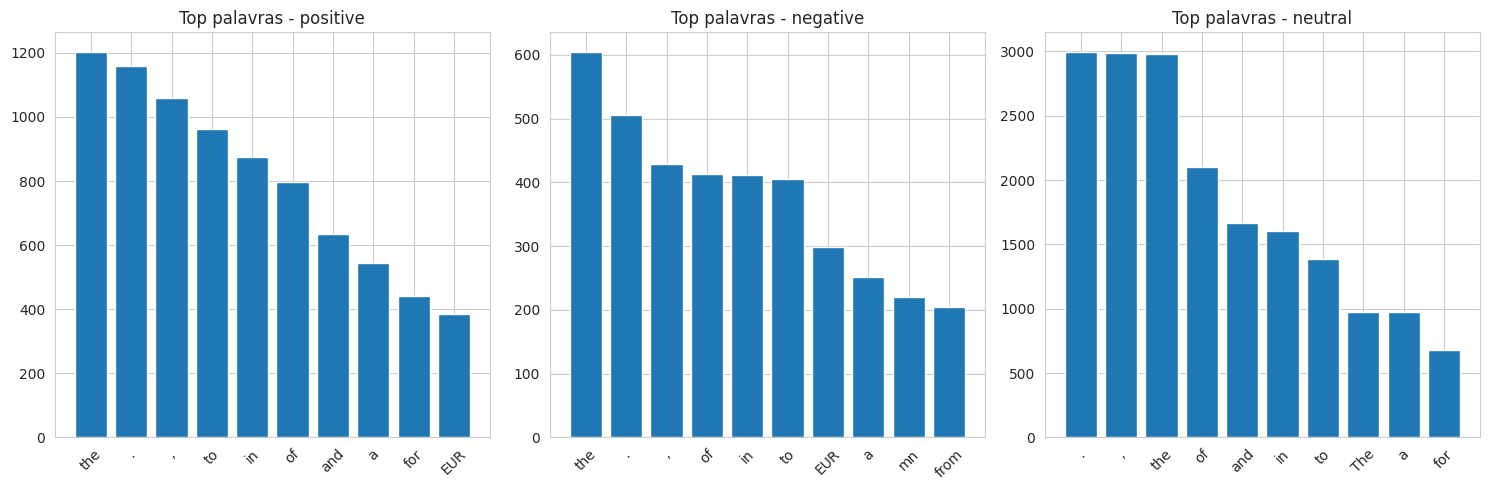

In [8]:
# Análise de frequência de palavras
def palavras_frequentes(frases, n=10):
    palavras = ' '.join(frases).split()
    return Counter(palavras).most_common(n)

# Criar visualização para palavras mais frequentes por sentimento
plt.figure(figsize=(15, 5))
for i, sentimento in enumerate(['positive', 'negative', 'neutral']):
    textos = dataset_df[dataset_df['Sentiment'] == sentimento]['Sentence']
    mais_freq = palavras_frequentes(textos)
    plt.subplot(1, 3, i+1)
    palavras, counts = zip(*mais_freq)
    plt.bar(palavras, counts)
    plt.title(f'Top palavras - {sentimento}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos verificar se existe alguma relação entre tamanho do texto, contagem de exclamações, interrogações e palavras em caixa alta com o sentimento do texto. Para isso, iremos criar algumas características básicas do texto original, como o tamanho do texto, a contagem de exclamações e interrogações, e a contagem de palavras em caixa alta.

Outras características serão extraídas do dicionário Loughran-McDonald, que contém palavras associadas a sentimentos financeiros. Essas características incluem contagens de palavras positivas, negativas, de incerteza, litigiosas e constrangedoras.

Em seguida aplicaremos visualizações e teste de hipótese Kruskal-Wallis para analisar a distribuição dessas características em relação aos sentimentos. Isso nos ajudará a identificar padrões e relações entre as características do texto e os sentimentos expressos.

INICIANDO ANÁLISE DE SENTIMENTOS FINANCEIROS
Dicionário LM carregado: ../data/Loughran-McDonald_MasterDictionary_1993-2024.csv

Criando features...

Balanceando dataset...
Dataset balanceado: 2580 amostras (860 por classe)

Distribuição das classes:
Sentiment
neutral     860
negative    860
positive    860
Name: count, dtype: int64

Testando significância estatística...
Testando 14 features (alpha=0.05)

Feature: comprimento_texto
  Kruskal-Wallis: H=38.252, p=0.0000 - Significativo

Feature: num_palavras
  Kruskal-Wallis: H=41.948, p=0.0000 - Significativo

Feature: comprimento_medio_palavra
  Kruskal-Wallis: H=18.377, p=0.0001 - Significativo

Feature: tamanho_texto
  Kruskal-Wallis: H=38.252, p=0.0000 - Significativo

Feature: qtd_palavras
  Kruskal-Wallis: H=10.265, p=0.0059 - Significativo

Feature: qtd_exclamacao
  Kruskal-Wallis: H=17.623, p=0.0001 - Significativo

Feature: qtd_interrogacao
  Kruskal-Wallis: H=11.115, p=0.0039 - Significativo

Feature: razao_caixa_alta
  Kruskal

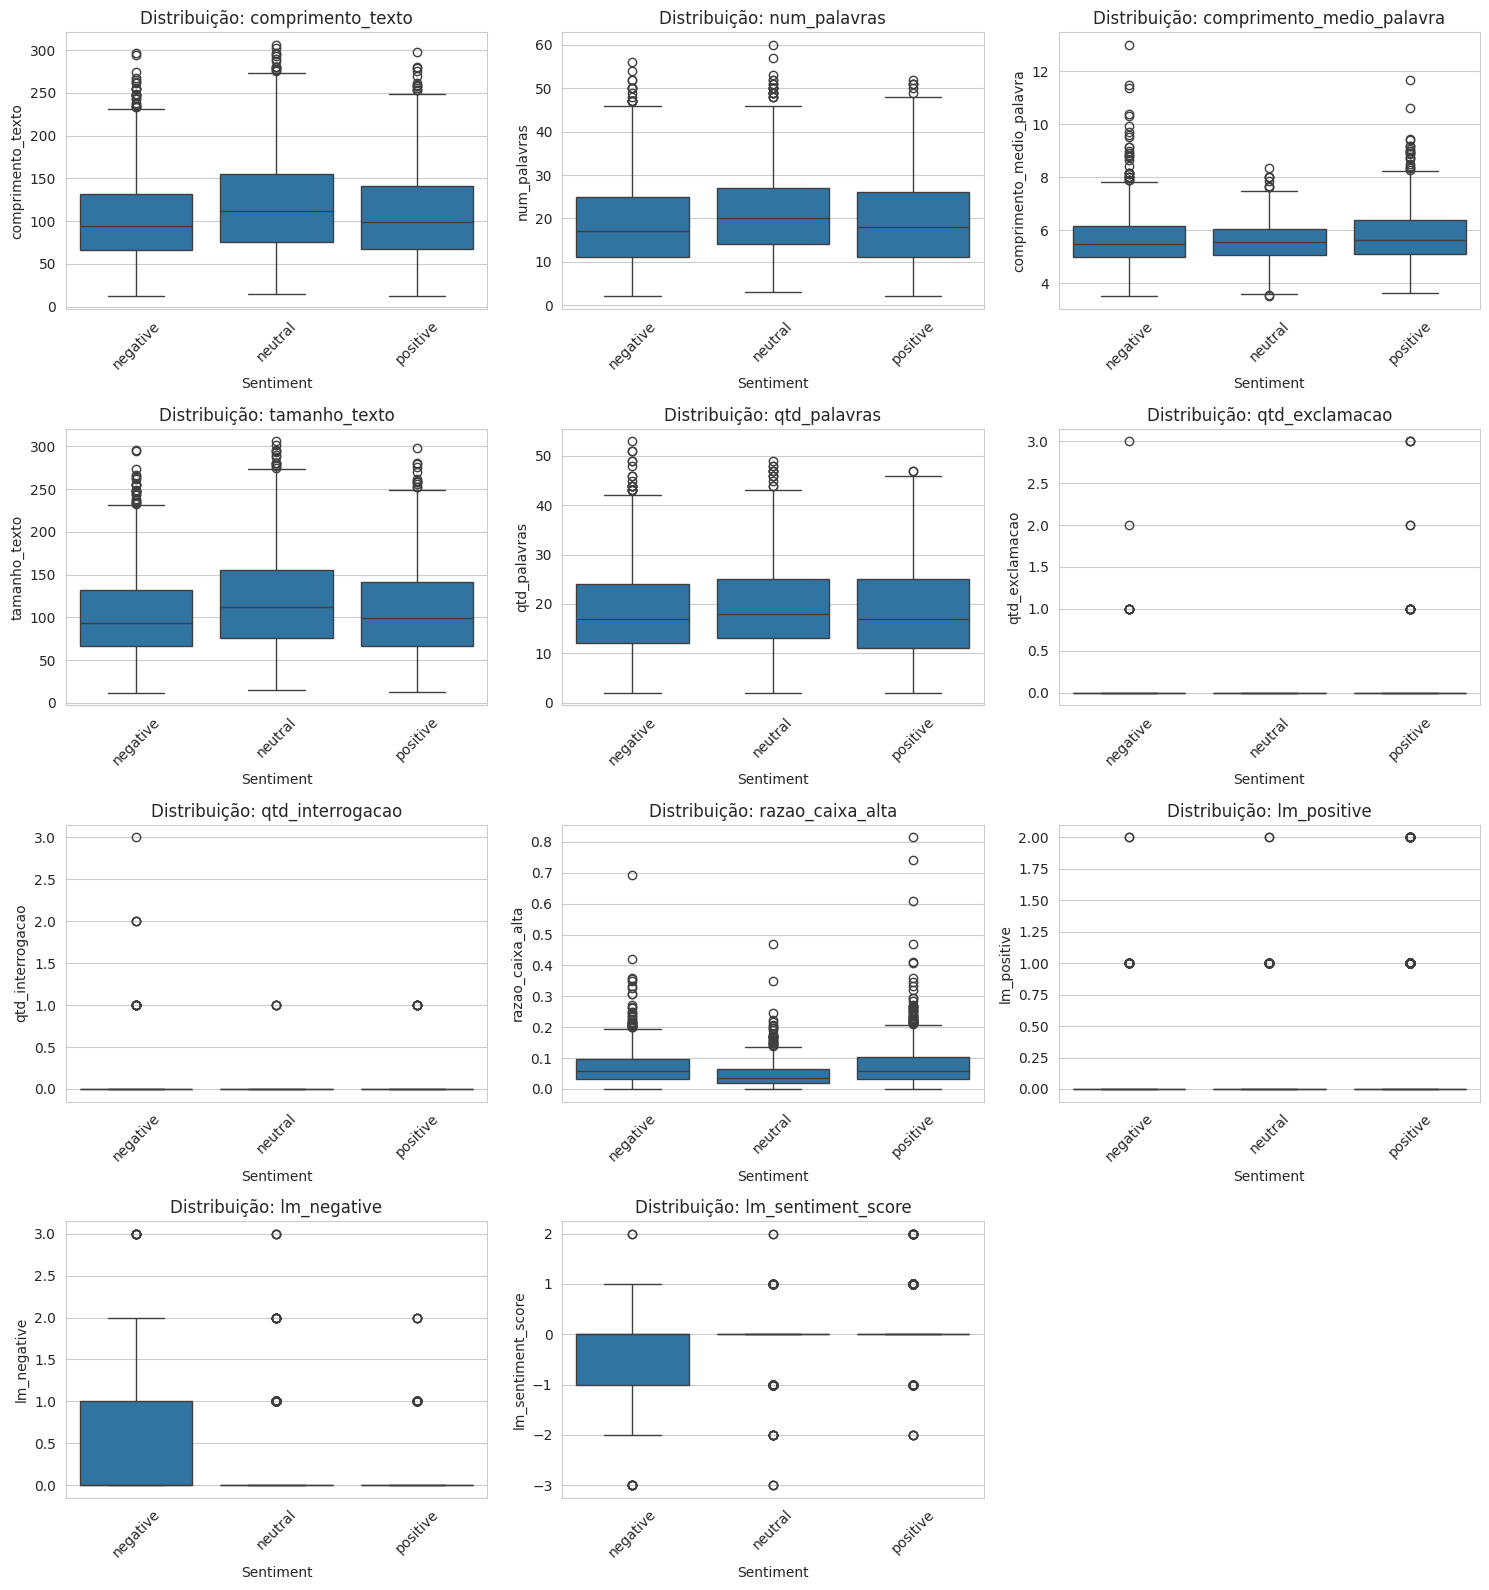


Primeiras linhas com features:


,Sentence,Sentiment,comprimento_texto,num_palavras,comprimento_medio_palavra,tamanho_texto,qtd_palavras,qtd_exclamacao,qtd_interrogacao,razao_caixa_alta,lm_positive,lm_negative
0,"Ruukki 's delivery includes steel structures ,...",neutral,144,22,6.545455,144,19,0,0,0.013889,0,0
1,Operating profit excluding non-recurring items...,negative,97,15,6.466667,97,17,0,0,0.072165,0,0
2,The parties have agreed not to disclose the tr...,neutral,63,11,5.727273,63,10,0,0,0.015873,0,1
3,"Paper companies were in negative territories ,...",neutral,178,35,5.085714,178,40,0,0,0.056180,0,1
4,Added. Cost now at 1.54. Bounce off of Put OI ...,positive,129,28,4.607143,129,29,0,0,0.124031,0,0


In [9]:
# Configurar o caminho do dicionário LM
LM_FILE_PATH = "../data/Loughran-McDonald_MasterDictionary_1993-2024.csv"

# Executar análise
df_processed, test_results = run_sentiment_analysis(
    df=dataset_df,  # Seu DataFrame original
    lm_file_path=LM_FILE_PATH,
    use_balanced=True,  # Mude para False se não quiser balancear
    show_output=True
)

# Ver primeiras linhas com features
feature_cols = [col for col in df_processed.columns if col not in ['Sentence', 'Sentiment']]
print("\nPrimeiras linhas com features:")
display(df_processed[['Sentence', 'Sentiment'] + feature_cols[:10]].head())


Notamos então que algumas das features criadas a partir do dicionário Loughran-McDonald (LM) e as características básicas do texto apresentam diferenças significativas entre os sentimentos.

### Análise do Score de cada Palavra com TF-IDF.

É importante também analisar o score de cada palavra, na frase, em relação ao sentimento, para entender quais palavras são mais relevantes para cada classe. Para isso, utilizaremos a técnica TF-IDF (Term Frequency-Inverse Document Frequency), que mede a importância de uma palavra em um documento em relação a um corpus de documentos.

In [10]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=2000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df_processed['Sentence'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores_array = X_tfidf.toarray() # Renomeado de tfidf_scores para evitar conflito com o DataFrame
tfidf_df = pd.DataFrame(tfidf_scores_array, columns=feature_names)

# Calcular a média dos scores TF-IDF para cada palavra em cada classe
for sentiment in df_processed['Sentiment'].unique():
    sentiment_mask = df_processed['Sentiment'] == sentiment
    mean_scores = tfidf_scores_array[sentiment_mask].mean(axis=0)
    print(f"\n--- Média dos scores TF-IDF para a classe '{sentiment}' ---")

    # Exibir as 10 palavras com maior score médio
    top_indices = np.argsort(mean_scores)[-10:][::-1]  # Índices das 10 palavras com maior score
    top_words = [(feature_names[i], mean_scores[i]) for i in top_indices]
    for word, score in top_words:
        print(f"Palavra: '{word}', Score: {score:.4f}")




--- Média dos scores TF-IDF para a classe 'neutral' ---
Palavra: 'eur', Score: 0.0285
Palavra: 'company', Score: 0.0272
Palavra: 'finland', Score: 0.0169
Palavra: 'million', Score: 0.0164
Palavra: 'mn', Score: 0.0158
Palavra: 'said', Score: 0.0150
Palavra: 'shares', Score: 0.0131
Palavra: 'sales', Score: 0.0125
Palavra: 'value', Score: 0.0124
Palavra: 'business', Score: 0.0123

--- Média dos scores TF-IDF para a classe 'negative' ---
Palavra: 'eur', Score: 0.0434
Palavra: 'mn', Score: 0.0372
Palavra: 'profit', Score: 0.0247
Palavra: 'sales', Score: 0.0231
Palavra: 'eur mn', Score: 0.0206
Palavra: 'year', Score: 0.0200
Palavra: 'https', Score: 0.0177
Palavra: 'operating', Score: 0.0176
Palavra: 'quarter', Score: 0.0163
Palavra: 'net', Score: 0.0159

--- Média dos scores TF-IDF para a classe 'positive' ---
Palavra: 'eur', Score: 0.0285
Palavra: 'sales', Score: 0.0222
Palavra: 'year', Score: 0.0202
Palavra: 'mn', Score: 0.0188
Palavra: 'long', Score: 0.0169
Palavra: 'company', Score: 0.0

Notamos que muitas das palavras se repetem, no entanto, algumas palavras são relevantes para cada grupo como "profit" e "million" para positivo, "loss" para negativo. Essas palavras podem ser indicativas de sentimentos financeiros específicos.

### Random Forest para análise da Importância de cada Palavra e Atributo

Para ter certeza da importância de cada palavra e atributo, utilizaremos o modelo Random Forest, que é um modelo de aprendizado de máquina baseado em árvores de decisão. Ele é capaz de lidar com dados complexos e não lineares, além de fornecer uma medida de importância para cada feature.

Tomaremos essa medida para ter certeza que estamos adicionando features relevantes para o modelo, e assim, melhorar a acurácia do modelo.

In [11]:
numerical_features = df_processed[[col for col in df_processed.columns if col not in ['Sentence', 'Sentiment']]]
X_combined = np.hstack((X_tfidf.toarray(), numerical_features))

# Treinar o modelo Random Forest
kfold = KFold(n_splits=5, shuffle=True)
splits = kfold.split(X_combined)

importances = np.array([])
for (train_index, test_index) in splits:
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = df_processed['Sentiment'].iloc[train_index], df_processed['Sentiment'].iloc[test_index]

    # Treinar o modelo Random Forest
    rf_model = RandomForestClassifier(n_jobs=-1)
    rf_model.fit(X_train, y_train)

    importances = np.hstack((importances, rf_model.feature_importances_))


# Calcular a média das importâncias
importance_mean = np.mean(importances.reshape(-1, X_train.shape[1]), axis=0)
importance_std = np.std(importances.reshape(-1, X_train.shape[1]), axis=0)

numerical_features_names = numerical_features.columns.values
feature_names = np.concatenate([feature_names, numerical_features_names])

# Criar um DataFrame com as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_mean})
# Ordenar as importâncias
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Exibir as 10 palavras mais importantes
top_importances = importance_df.head(10)
print("\n--- 10 Features/Palavras mais Importantes ---")
for index, row in top_importances.iterrows():
    print(f"Palavra: '{row['Feature']}', Importância: {row['Importance']:.4f}")



--- 10 Features/Palavras mais Importantes ---
Palavra: 'lm_sentiment_score', Importância: 0.0359
Palavra: 'razao_caixa_alta', Importância: 0.0340
Palavra: 'lm_negative', Importância: 0.0286
Palavra: 'comprimento_medio_palavra', Importância: 0.0276
Palavra: 'tamanho_texto', Importância: 0.0233
Palavra: 'comprimento_texto', Importância: 0.0228
Palavra: 'num_palavras', Importância: 0.0208
Palavra: 'qtd_palavras', Importância: 0.0183
Palavra: 'lm_positive', Importância: 0.0145
Palavra: 'sales', Importância: 0.0073
